In [ ]:
# Import necessary libraries
import os
import gzip
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from scipy.sparse import coo_matrix
from torch_geometric.nn import MessagePassing
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_scatter import scatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold

In [ ]:
# import xbar data (unprocessed)
data_path = "NCSU-DigIC-GraphData-2023-07-25/"

In [ ]:
# Load design data
with gzip.open(os.path.join(data_path, "xbar/1/xbar.json.gz"), "rb") as f:
    design = json.loads(f.read().decode("utf-8"))

# Create DataFrames
instances = pd.DataFrame(design["instances"])
nets = pd.DataFrame(design["nets"])

print("Instances shape:", instances.shape)
print("Nets shape:", nets.shape)
print(instances.head())

Instances shape: (3952, 6)
Nets shape: (4482, 2)
                       name  id   xloc   yloc  cell  orient
0    clk_gate_out_reg/latch   0  41984  44544    23       0
1  clk_gate_out_reg_0/latch   1  41984  47616    23       6
2  clk_gate_out_reg_1/latch   2  44160  44544    23       0
3  clk_gate_out_reg_2/latch   3  44160  47616    23       0
4  clk_gate_out_reg_3/latch   4  46336  47616    23       0


In [ ]:
# Load connectivity data
conn = np.load(os.path.join(data_path, "xbar/1/xbar_connectivity.npz"))
A = coo_matrix((conn["data"], (conn["row"], conn["col"])), shape=conn["shape"])

# Ensure matrix symmetry
A = A.__mul__(A.T)

print("Adjacency matrix shape:", A.shape)

Adjacency matrix shape: (3952, 3952)


In [ ]:
# Load congestion data
congestion_data = np.load(os.path.join(data_path, "xbar/1/xbar_congestion.npz"))

# Inspect keys and boundary lists
print(congestion_data.files)
print("xBoundaryList:", congestion_data["xBoundaryList"])
print("yBoundaryList:", congestion_data["yBoundaryList"])


# Build boundary segment trees
def buildBST(array, start=0, finish=-1):
    if finish < 0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid - start == 1:
        ltl = start
    else:
        ltl = buildBST(array, start, mid)
    if finish - mid == 1:
        gtl = mid
    else:
        gtl = buildBST(array, mid, finish)
    return (array[mid], ltl, gtl)


xbst = buildBST(congestion_data["xBoundaryList"])
ybst = buildBST(congestion_data["yBoundaryList"])

['demand', 'capacity', 'xBoundaryList', 'yBoundaryList', 'layerList']
xBoundaryList: [    0  2048  3584  5120  6656  8192  9728 11264 12800 14336 15872 17408
 18944 20480 22016 23552 25088 26624 28160 29696 31232 32768 34304 35840
 37376 38912 40448 41984 43520 45056 46592 48128 49664 51200 52736 54272
 55808 57344 58880 60416 61952 63488 65024 66560 68096 69632 71168 72704
 74240 75776 77312 78848 80384 81920 83456 84992 86528]
yBoundaryList: [    0  1536  3072  4608  6144  7680  9216 10752 12288 13824 15360 16896
 18432 19968 21504 23040 24576 26112 27648 29184 30720 32256 33792 35328
 36864 38400 39936 41472 43008 44544 46080 47616 49152 50688 52224 53760
 55296 56832 58368 59904 61440 62976 64512 66048 67584 69120 70656 72192
 73728 75264 76800 78336 79872 81408 82944 84480 86016 87552]


In [ ]:
# Initialize demand and capacity arrays
demand = np.zeros(instances.shape[0])
capacity = np.zeros(instances.shape[0])


# Helper function to get grid cell index
def getGRCIndex(x, y, xbst, ybst):
    while isinstance(xbst, tuple):
        if x < xbst[0]:
            xbst = xbst[1]
        else:
            xbst = xbst[2]
    while isinstance(ybst, tuple):
        if y < ybst[0]:
            ybst = ybst[1]
        else:
            ybst = ybst[2]
    return ybst, xbst


# Map congestion data
for k in range(instances.shape[0]):
    xloc, yloc = instances.iloc[k]["xloc"], instances.iloc[k]["yloc"]
    try:
        i, j = getGRCIndex(xloc, yloc, xbst, ybst)
        d = sum(
            congestion_data["demand"][lyr][i][j]
            for lyr in range(len(congestion_data["layerList"]))
        )
        c = sum(
            congestion_data["capacity"][lyr][i][j]
            for lyr in range(len(congestion_data["layerList"]))
        )
        demand[k] = d
        capacity[k] = c
    except IndexError:
        print(f"Out-of-bounds for instance {k} at xloc: {xloc}, yloc: {yloc}")

# Add columns to instances DataFrame
instances["routing_demand"] = demand
instances["routing_capacity"] = capacity
instances["congestion"] = demand - capacity

print(instances.head())

                       name  id   xloc   yloc  cell  orient  routing_demand  \
0    clk_gate_out_reg/latch   0  41984  44544    23       0            20.0   
1  clk_gate_out_reg_0/latch   1  41984  47616    23       6            23.0   
2  clk_gate_out_reg_1/latch   2  44160  44544    23       0            23.0   
3  clk_gate_out_reg_2/latch   3  44160  47616    23       0            22.0   
4  clk_gate_out_reg_3/latch   4  46336  47616    23       0            21.0   

   routing_capacity  congestion  
0              28.0        -8.0  
1              28.0        -5.0  
2              33.0       -10.0  
3              33.0       -11.0  
4              23.0        -2.0  


In [ ]:
# Continuous features to normalize
continuous_features = ["xloc", "yloc", "routing_demand", "routing_capacity"]

scaler = MinMaxScaler()
normalized_continuous = scaler.fit_transform(instances[continuous_features])

# One-hot encode the 'orient' feature
onehotencoder = OneHotEncoder()
orient_encoded = onehotencoder.fit_transform(instances[["orient"]]).toarray()

# Combine normalized features and one-hot encoded features
node_features = np.hstack([normalized_continuous, orient_encoded])
x_nodes = torch.tensor(node_features, dtype=torch.float)

print("Node features shape:", x_nodes.shape)  # Should be (num_nodes, num_features)

Node features shape: torch.Size([3952, 8])


In [ ]:
num_nets = A.shape[1] - len(
    instances
)  # Nets are the remaining rows/columns in adjacency matrix
x_nets = torch.zeros(num_nets, x_nodes.shape[1])  # Initialize net features as zeros

# Combine node and net features
x_combined = torch.cat([x_nodes, x_nets], dim=0)
print(
    "Combined feature matrix shape:", x_combined.shape
)  # Should be (num_nodes + num_nets, num_features)

Combined feature matrix shape: torch.Size([3952, 8])


In [ ]:
# Ensure A is in COO format
A_coo = A.tocoo()

# Extract edge indices
node_to_net_edge_index = torch.tensor(
    np.vstack((A_coo.row, A_coo.col)), dtype=torch.long
)
net_to_node_edge_index = torch.tensor(
    np.vstack((A_coo.col, A_coo.row)), dtype=torch.long
)

# Combine the edge indices
edge_index = torch.cat([node_to_net_edge_index, net_to_node_edge_index], dim=1)
print("Edge index shape:", edge_index.shape)  # Should be (2, num_edges)

Edge index shape: torch.Size([2, 282944])


In [ ]:
# Use congestion as the target variable
targets = torch.tensor(instances["congestion"].values, dtype=torch.float).view(-1, 1)

# Create the Data object
hypergraph_data = Data(x=x_combined, edge_index=edge_index, y=targets)

# Inspect the Data object
print(hypergraph_data)

Data(x=[3952, 8], edge_index=[2, 282944], y=[3952, 1])


In [204]:
hypergraph_data.x

tensor([[0.4962, 0.5000, 0.5135,  ..., 0.0000, 0.0000, 0.0000],
        [0.4962, 0.5357, 0.5946,  ..., 0.0000, 0.0000, 1.0000],
        [0.5222, 0.5000, 0.5946,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2726, 0.7500, 0.7027,  ..., 0.0000, 0.0000, 0.0000],
        [0.4793, 0.5000, 0.7297,  ..., 0.0000, 0.0000, 0.0000],
        [0.5544, 0.5000, 0.5946,  ..., 0.0000, 0.0000, 1.0000]])

In [205]:
hypergraph_data.edge_index

tensor([[   0,    0,    0,  ...,    1,    0, 3951],
        [3951, 3950,   11,  ..., 3951, 3951, 3951]])

In [206]:
hypergraph_data.y

tensor([[ -8.],
        [ -5.],
        [-10.],
        ...,
        [ -2.],
        [ -5.],
        [-13.]])

In [ ]:
class HyperConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HyperConvLayer, self).__init__()
        self.mlp = Seq(Linear(in_channels, out_channels), ReLU())

    def forward(self, x, edge_index):
        # Aggregate information from neighbors
        row, col = edge_index
        x_aggregated = scatter(x[row], col, dim=0, reduce="mean")
        return self.mlp(x_aggregated)


class DEHNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(DEHNN, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(HyperConvLayer(in_channels, hidden_channels))
            in_channels = hidden_channels
        self.output_layer = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index)
        return self.output_layer(x[: len(instances)])  # Predict only for nodes

In [ ]:
# Define model parameters
hidden_dim = 64
out_dim = 1  # Single output for regression
num_layers = 3

# Initialize the DEHNN model
model = DEHNN(x_combined.size(1), hidden_dim, out_dim, num_layers)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error for regression

In [ ]:
# Training loop
model.train()
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    predictions = model(hypergraph_data.x, hypergraph_data.edge_index)

    # Compute loss
    loss = criterion(predictions, hypergraph_data.y)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/1000, Loss: 17.0813
Epoch 2/1000, Loss: 17.0693
Epoch 3/1000, Loss: 17.0570
Epoch 4/1000, Loss: 17.0450
Epoch 5/1000, Loss: 17.0338
Epoch 6/1000, Loss: 17.0237
Epoch 7/1000, Loss: 17.0149
Epoch 8/1000, Loss: 17.0072
Epoch 9/1000, Loss: 17.0006
Epoch 10/1000, Loss: 16.9946
Epoch 11/1000, Loss: 16.9891
Epoch 12/1000, Loss: 16.9837
Epoch 13/1000, Loss: 16.9781
Epoch 14/1000, Loss: 16.9722
Epoch 15/1000, Loss: 16.9659
Epoch 16/1000, Loss: 16.9590
Epoch 17/1000, Loss: 16.9518
Epoch 18/1000, Loss: 16.9441
Epoch 19/1000, Loss: 16.9361
Epoch 20/1000, Loss: 16.9280
Epoch 21/1000, Loss: 16.9199
Epoch 22/1000, Loss: 16.9118
Epoch 23/1000, Loss: 16.9037
Epoch 24/1000, Loss: 16.8955
Epoch 25/1000, Loss: 16.8871
Epoch 26/1000, Loss: 16.8783
Epoch 27/1000, Loss: 16.8689
Epoch 28/1000, Loss: 16.8589
Epoch 29/1000, Loss: 16.8483
Epoch 30/1000, Loss: 16.8373
Epoch 31/1000, Loss: 16.8263
Epoch 32/1000, Loss: 16.8156
Epoch 33/1000, Loss: 16.8048
Epoch 34/1000, Loss: 16.7943
Epoch 35/1000, Loss: 16

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(hypergraph_data.x, hypergraph_data.edge_index)
    print("Predictions shape:", predictions.shape)

    # Compute Mean Absolute Error
    mae = torch.mean(torch.abs(predictions - hypergraph_data.y))
    print(f"Mean Absolute Error: {mae.item():.4f}")

Predictions shape: torch.Size([3952, 1])
Mean Absolute Error: 2.6343


In [ ]:
# Check for missing values
print("Checking for missing values in instances:")
print(instances.isnull().sum())

# Ensure all columns have valid data types
print("\nInstances data types:")
print(instances.dtypes)

# Check for unique values in categorical features (e.g., 'orient')
print("\nUnique values in 'orient':")
print(instances["orient"].unique())

Checking for missing values in instances:
name                0
id                  0
xloc                0
yloc                0
cell                0
orient              0
routing_demand      0
routing_capacity    0
congestion          0
dtype: int64

Instances data types:
name                 object
id                    int64
xloc                  int64
yloc                  int64
cell                  int64
orient                int64
routing_demand      float64
routing_capacity    float64
congestion          float64
dtype: object

Unique values in 'orient':
[0 6 4 2]


In [ ]:
# Generate descriptive statistics
print("\nDescriptive statistics for instances:")
print(instances.describe())

# Target variable distribution
print("\nDescriptive statistics for congestion:")
print(instances["congestion"].describe())


Descriptive statistics for instances:
               id          xloc          yloc         cell       orient  \
count  3952.00000   3952.000000   3952.000000  3952.000000  3952.000000   
mean   1975.50000  42760.388664  44582.089069    38.986589     2.960526   
std    1140.98846  21896.568811  21783.721969    21.323509     2.939784   
min       0.00000    512.000000   1536.000000     0.000000     0.000000   
25%     987.75000  23936.000000  26112.000000     9.000000     0.000000   
50%    1975.50000  42624.000000  44544.000000    48.000000     2.000000   
75%    2963.25000  61312.000000  62976.000000    56.000000     6.000000   
max    3951.00000  84096.000000  87552.000000    65.000000     6.000000   

       routing_demand  routing_capacity   congestion  
count     3952.000000       3952.000000  3952.000000  
mean        25.646255         33.018725    -7.372470  
std          4.521986          3.580319     4.116739  
min          1.000000         20.000000   -35.000000  
25%       

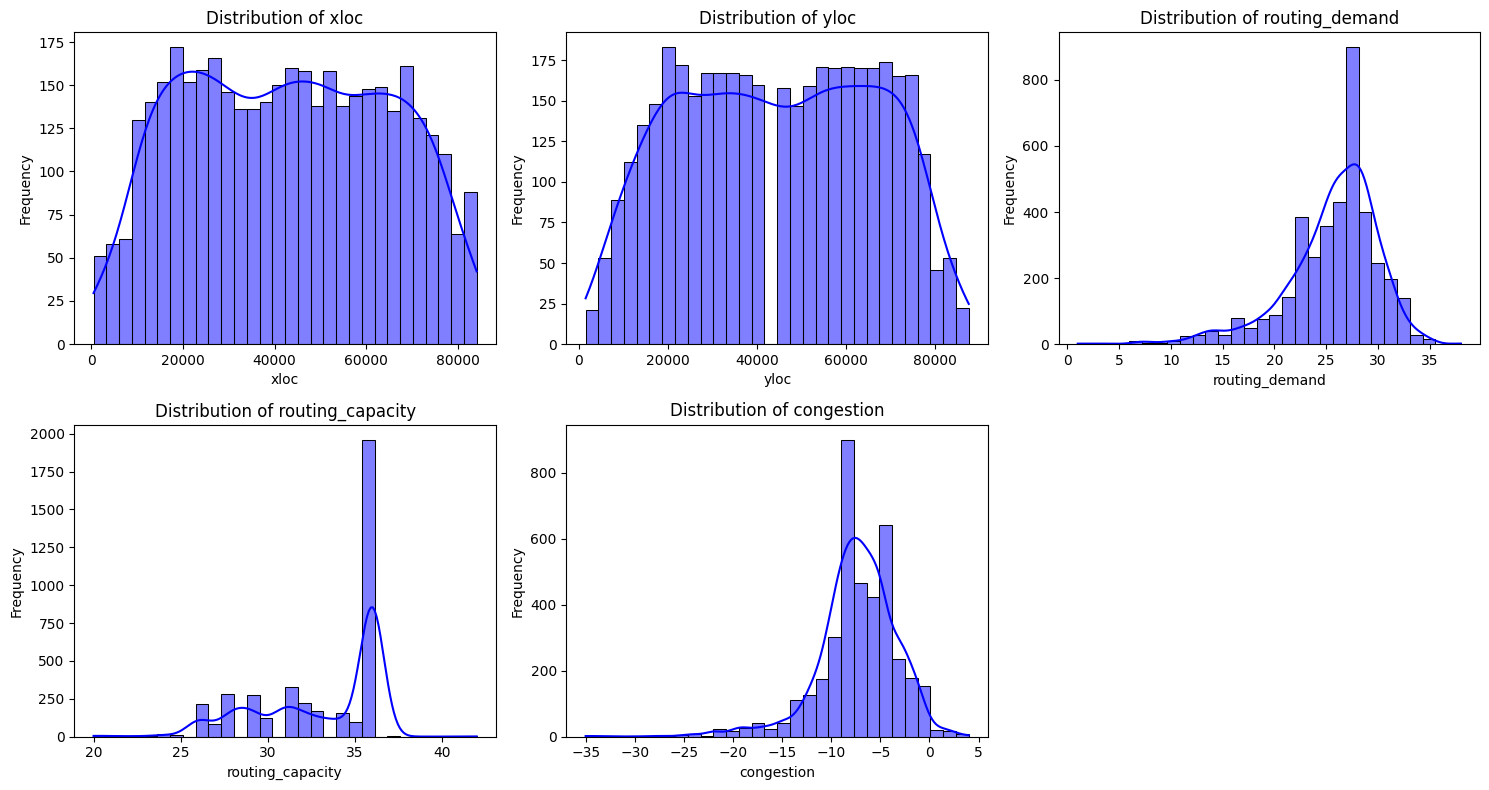

In [ ]:
# Plot distribution of numerical features
numeric_cols = ["xloc", "yloc", "routing_demand", "routing_capacity", "congestion"]
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(instances[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

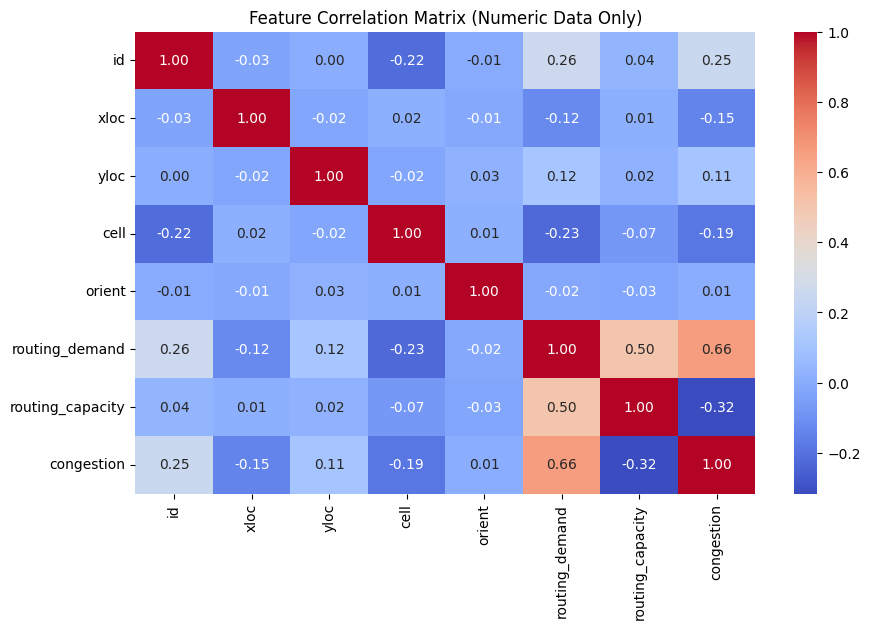

In [ ]:
# Exclude non-numeric columns
numeric_instances = instances.select_dtypes(include=["float64", "int64"])

# Compute correlation matrix
corr_matrix = numeric_instances.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix (Numeric Data Only)")
plt.show()

In [ ]:
# Detect outliers using IQR
Q1 = instances["congestion"].quantile(0.25)
Q3 = instances["congestion"].quantile(0.75)
IQR = Q3 - Q1
outliers = instances[
    (instances["congestion"] < (Q1 - 1.5 * IQR))
    | (instances["congestion"] > (Q3 + 1.5 * IQR))
]

print(f"Number of outliers in 'congestion': {len(outliers)}")
print(outliers)

Number of outliers in 'congestion': 182
             name    id   xloc   yloc  cell  orient  routing_demand  \
13    out_reg_31_    13    512   7680    65       6            10.0   
15    out_reg_29_    15    512  26112    65       6            14.0   
20    out_reg_24_    20    640   1536    65       0             7.0   
21    out_reg_23_    21    512  26112    65       0            14.0   
22    out_reg_22_    22  83456  47616    65       4            15.0   
...           ...   ...    ...    ...   ...     ...             ...   
3664        U7424  3664  74368  10752    46       0            16.0   
3780        U7552  3780  29824  50688    56       0            29.0   
3839        U3629  3839   4352  78336    34       0            14.0   
3840        U3711  3840   8704  84480    34       6            13.0   
3854        U5172  3854   8704  75264     0       0            20.0   

      routing_capacity  congestion  
13                36.0       -26.0  
15                30.0       -16.

In [ ]:
# Split data
train_data, test_data = train_test_split(instances, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Training Set: {train_data.shape}")
print(f"Validation Set: {val_data.shape}")
print(f"Test Set: {test_data.shape}")

Training Set: (2528, 9)
Validation Set: (633, 9)
Test Set: (791, 9)


In [ ]:
scaler = MinMaxScaler()
train_data_scaled = train_data.copy()
val_data_scaled = val_data.copy()
test_data_scaled = test_data.copy()

features_to_scale = ["xloc", "yloc", "routing_demand", "routing_capacity"]
train_data_scaled[features_to_scale] = scaler.fit_transform(
    train_data[features_to_scale]
)
val_data_scaled[features_to_scale] = scaler.transform(val_data[features_to_scale])
test_data_scaled[features_to_scale] = scaler.transform(test_data[features_to_scale])

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_data_scaled)):
    print(f"Fold {fold + 1}: Train indices {train_idx[:5]}, Val indices {val_idx[:5]}")

Fold 1: Train indices [0 1 2 3 4], Val indices [25 29 43 44 48]
Fold 2: Train indices [0 1 2 3 4], Val indices [ 8 13 18 20 23]
Fold 3: Train indices [0 1 3 4 5], Val indices [ 2  6 10 14 15]
Fold 4: Train indices [1 2 4 6 8], Val indices [0 3 5 7 9]
Fold 5: Train indices [0 2 3 5 6], Val indices [ 1  4 11 16 19]
